<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Вывод-1" data-toc-modified-id="Вывод-1-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Вывод 1</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Тренд" data-toc-modified-id="Тренд-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тренд</a></span></li><li><span><a href="#Вывод-2" data-toc-modified-id="Вывод-2-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод 2</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('C:/Users/School252/Downloads/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# Рассемплирование по одному часу
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Вывод 1

- Данные с 1 марта 2018 по 31 августа 2018, всего 26 496 записей, достаточно для анализа
- Пропусков нет, тип данных в столбце num_orders менять не надо
- Дубликаты искать бессмысленно, так как кол-во заказов из-за сезонности и времени суток может повторяться
- Данные ресемплированы по 1 часу по условию задачи

## Анализ

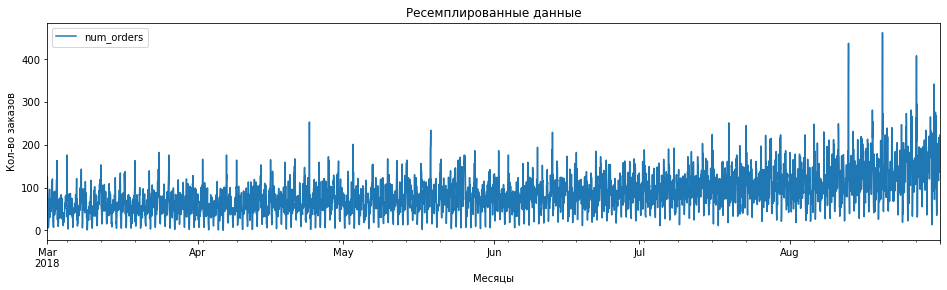

In [8]:
# график ресемплированных данных:
figsize = (16,4)
data.plot(figsize=figsize)
plt.title('Ресемплированные данные')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

Видны всплески заказов в августе месяце

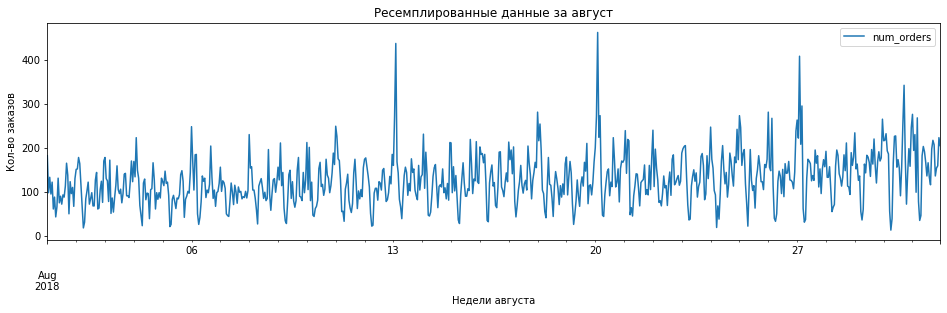

In [9]:
data_aug = data['2018-08-01':]
data_aug.plot(figsize=figsize)
plt.title('Ресемплированные данные за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

Выведем график с 13 числа

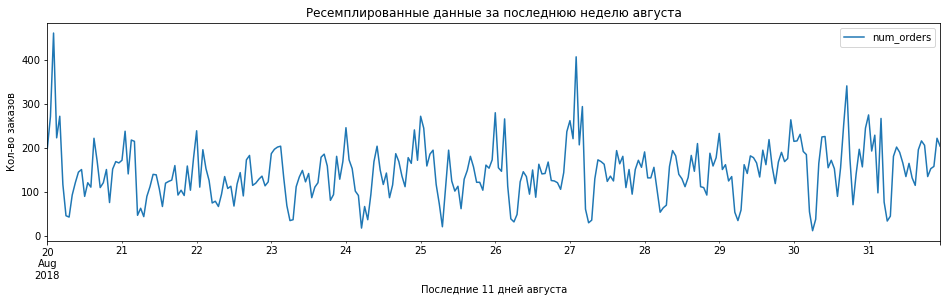

In [10]:
#вывожу график с 13 числа:
data_aug_11days = data['2018-08-20':]
data_aug_11days.plot(figsize=figsize)
plt.title('Ресемплированные данные за последнюю неделю августа')
plt.xlabel('Последние 11 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

Выведем 19 и 20 число

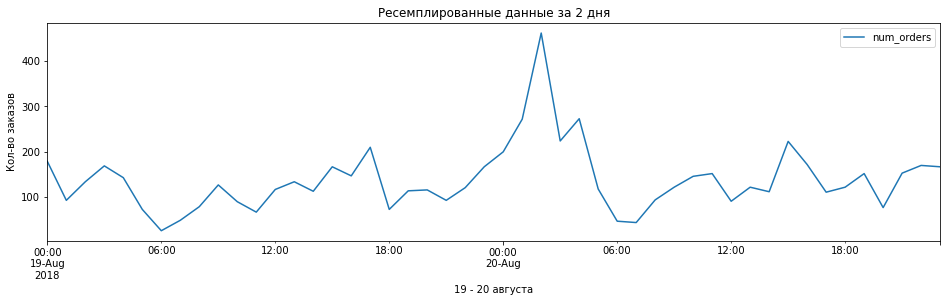

In [11]:
data_aug_1days = data['2018-08-19' : '2018-08-20']
data_aug_1days.plot(figsize=figsize)
plt.title('Ресемплированные данные за 2 дня')
plt.xlabel('19 - 20 августа')
plt.ylabel('Кол-во заказов')
plt.show()

Промежуточный вывод:

На графике ресемплированных по 1 часу данных видно, что кол-во заказов начинает возрастать, при этом в августе всплески заказов по понедельникам
Виден высокий рост после 18:00 и снижение к 6:00

### Скользящее среднее

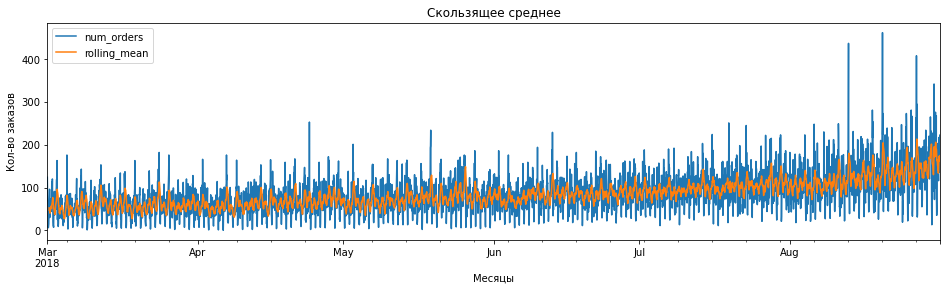

In [12]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot(figsize=figsize)
plt.title('Скользящее среднее')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

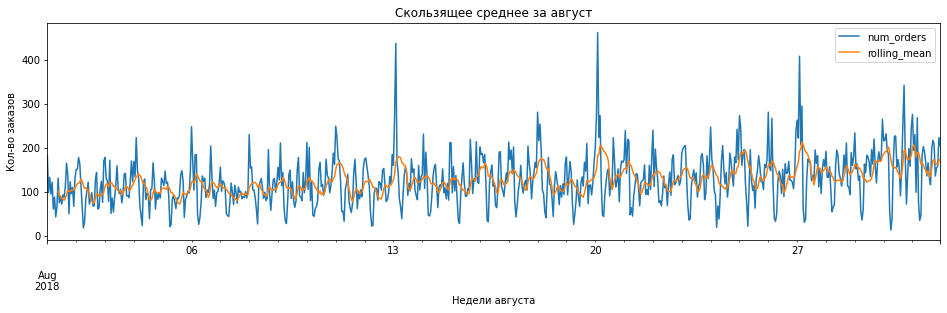

In [13]:
data_aug['rolling_mean'] = data_aug.rolling(10).mean()
data_aug.plot(figsize=figsize)
plt.title('Скользящее среднее за август')
plt.xlabel('Недели августа')
plt.ylabel('Кол-во заказов')
plt.show()

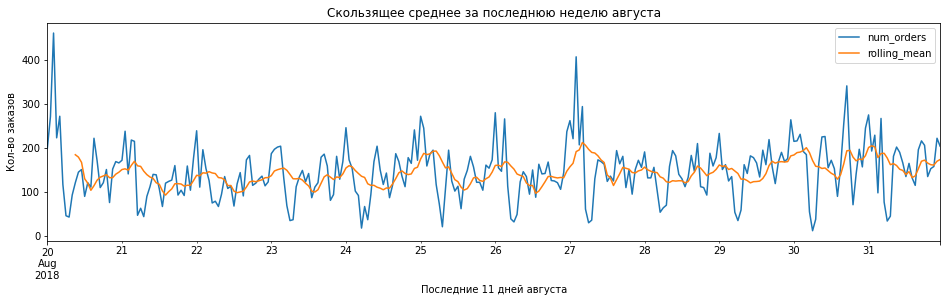

In [14]:
data_aug_11days['rolling_mean'] = data_aug_11days.rolling(10).mean()
data_aug_11days.plot(figsize=figsize)
plt.title('Скользящее среднее за последнюю неделю августа')
plt.xlabel('Последние 11 дней августа')
plt.ylabel('Кол-во заказов')
plt.show()

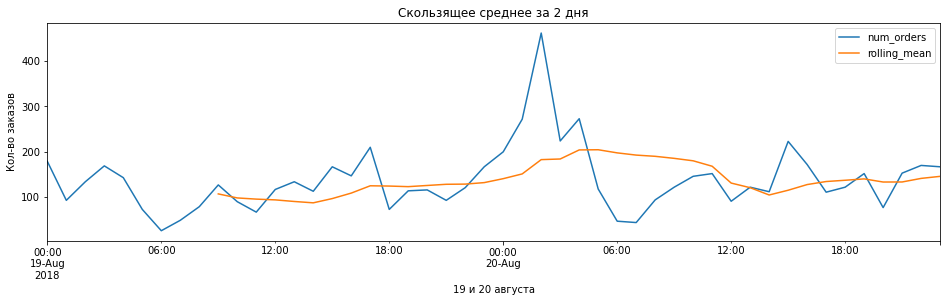

In [15]:
data_aug_1days['rolling_mean'] = data_aug_1days.rolling(10).mean()
data_aug_1days.plot(figsize=figsize)
plt.title('Скользящее среднее за 2 дня')
plt.xlabel('19 и 20 августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Тренд

In [16]:
decomposed = seasonal_decompose(data.num_orders)
decomposed_aug_1days = seasonal_decompose(data_aug_1days.num_orders)

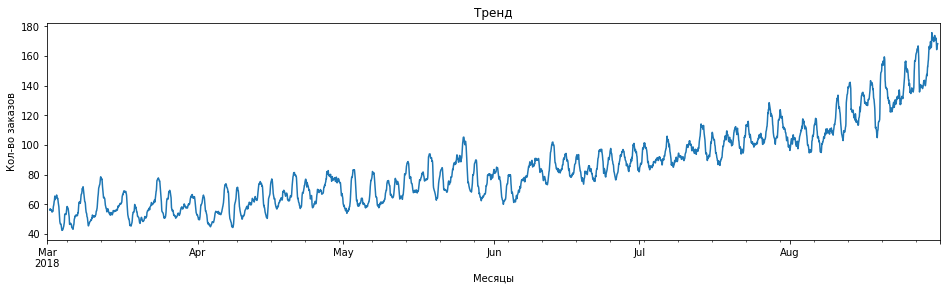

In [17]:
decomposed.trend.plot(figsize=figsize)
plt.title('Тренд')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

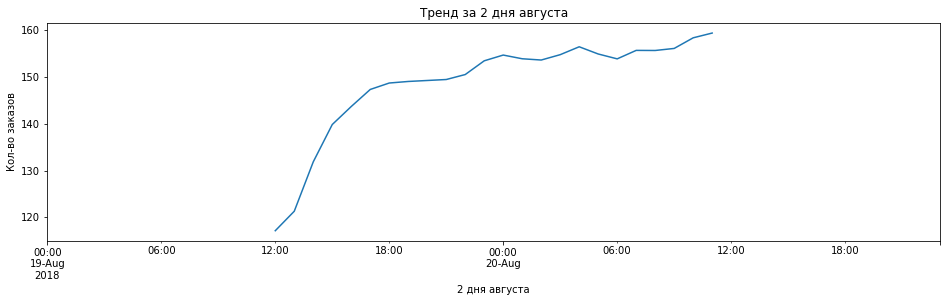

In [18]:
decomposed_aug_1days.trend.plot(figsize=figsize)
plt.title('Тренд за 2 дня августа')
plt.xlabel('2 дня августа')
plt.ylabel('Кол-во заказов')
plt.show()

### Вывод 2

- Тренд идет на явное возрастание, то есть он не стационарный - это видно и на графике тренда, и на графике ресемплированных по 1 часу данных
- Есть явная суточная сезонность - больше всего заказов 09:00 и после 00:00, меньше всего в районе 06:00.
- Дни по кол-ву заказов отличаются друг от друга, то есть надо будет учесть день
- По понедельникам есть увеличение заказов, то есть надо будет учесть день недели

In [19]:
# код ревьювера
from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


<br/>
<div class="alert alert-info">
Спасибо
</div>

## Обучение

In [20]:
#ввожу функцию признаков:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [21]:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [22]:
import time

class ModelHelper:
    def __init__(self, name, model):
        """Constructor"""
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, grid):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = (grid.best_score_ * -1)**0.5
        
    def prediction(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
        
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [23]:
def print_result(result):
    print('|{: >20}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >20}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(info[0], info[1], info[2], info[3]))

In [24]:
result = []

In [25]:
data = make_features(data, 97, 20)

In [26]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

### LGBMRegressor

In [27]:
gbm = LGBMRegressor(boosting_type='gbdt', verbose=0, force_col_wise=True)
gbm_params = {'learning_rate': np.logspace(-3, 0, 5), 'n_estimators': range(20, 61, 20), 'num_leaves': range(20, 41, 10)}
tscv = TimeSeriesSplit(n_splits=3)

grid_gbm = GridSearchCV(gbm, gbm_params, cv=tscv, scoring='neg_mean_squared_error')
grid_gbm.fit(features_train, target_train);

grid_gbm.best_params_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

{'learning_rate': 0.1778279410038923, 'n_estimators': 40, 'num_leaves': 20}

In [28]:
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train, target_train)
model_gbm_helper.predict(features_train, grid_gbm)
result.append(model_gbm_helper.getResult())

In [29]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|            LightGBM|           0.30181|           0.02026|    25.97965|


### CatBoost

In [30]:
cbr = CatBoostRegressor(loss_function='RMSE', silent=True)
cbr_params = {'learning_rate': np.logspace(-3, 0, 5),'iterations': range(20, 60, 20),'depth': range(5,10,2)}
tscv = TimeSeriesSplit(n_splits=3)

grid_cbr = GridSearchCV(cbr, cbr_params, cv=tscv, scoring='neg_mean_squared_error')
grid_cbr.fit(features_train, target_train);

grid_cbr.best_params_

{'depth': 5, 'iterations': 40, 'learning_rate': 0.1778279410038923}

In [31]:
model_cbr = grid_cbr.best_estimator_
model_cbr_helper = ModelHelper('CatBoost', model_cbr)
model_cbr_helper.fit(features_train, target_train)
model_cbr_helper.predict(features_train, grid_cbr)
result.append(model_cbr_helper.getResult())

In [32]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|            LightGBM|           0.30181|           0.02026|    25.97965|
|            CatBoost|           0.81813|           0.00000|    25.70039|


### RandomForest

In [33]:
parameters = {'n_estimators': range(5,11,5),'max_depth': range(1,8,3), 'min_samples_leaf': range(1,5,2), 'min_samples_split': range(2,6,2)}
tscv = TimeSeriesSplit(n_splits=3)

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 7,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 10}

In [34]:
model_forest = grid.best_estimator_
model_forest_helper = ModelHelper('Random forest', model_forest)
model_forest_helper.fit(features_train, target_train)
model_forest_helper.predict(features_train, grid)
result.append(model_forest_helper.getResult())

In [35]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|            LightGBM|           0.30181|           0.02026|    25.97965|
|            CatBoost|           0.81813|           0.00000|    25.70039|
|       Random forest|           1.51161|           0.01563|    26.69420|


Лучший показатель у модели LightGBM, проверим этумодель на тестовой выборке

### Тестирование

In [36]:
# Оцениваю на тестовой выборке
model_gbm = grid_gbm.best_estimator_
model_gbm_helper = ModelHelper('LightGBM', model_gbm)
model_gbm_helper.fit(features_train, target_train)
model_gbm_helper.prediction(features_test, target_test)
result.append(model_gbm_helper.getResult())

In [37]:
print_result(result)

|              Модель|    Время обучения|Время предсказания|        RMSE|
|            LightGBM|           0.30181|           0.02026|    25.97965|
|            CatBoost|           0.81813|           0.00000|    25.70039|
|       Random forest|           1.51161|           0.01563|    26.69420|
|            LightGBM|           0.26415|           0.00203|    38.92000|


In [38]:
prediction_g = model_gbm.predict(features_test)

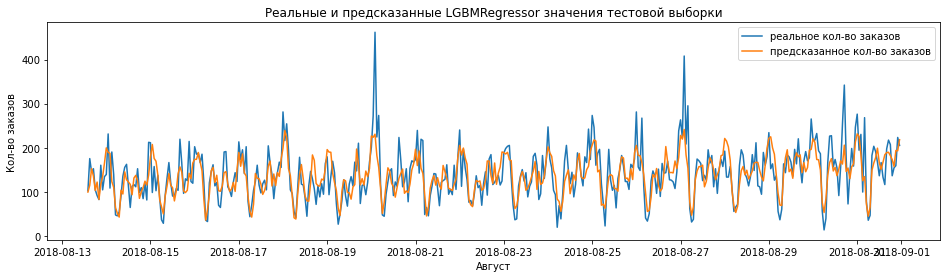

In [39]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, label='реальное кол-во заказов')
ax.plot(target_test.index, prediction_g, label='предсказанное кол-во заказов')
plt.title('Реальные и предсказанные LGBMRegressor значения тестовой выборки')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

Почти, но на всплесках предсказания не точны

### Вывод

- Обучил 3 модели - CatBoost, дерево решений и LGBMRegressor - со сменой параметров.
- Наилучший результат дала LGBMRegressor - на тестовой выборке RMSE = 38

В проекте:

1. загрузил данные
2. провел их анализ
3. сравнил 3 модели с разными гиперпараметрами, проверил лучшую на тестовой выборке
4. выбрал лучшую модель по RMSE

In [40]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [41]:
print('RMSE:', mean_squared_error(target_test, pred_previous))

RMSE: 3464.085972850679


Модель прошла проверку